# PIN (Probability of Informed Trading)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy import optimize

In [2]:
Raw = pd.read_csv('2017-11-09_005930.csv', index_col = 0)
Processed = pd.read_csv('BuySell_Intensity.csv', index_col = 0)
Raw = Raw[1:-1]
Raw.index = pd.TimedeltaIndex(Raw.index)

data = Raw['close'].resample('300s').ohlc()
data.index = pd.TimedeltaIndex(Processed.index)

data['Sell'] = Processed['Sell']
data['Buy'] = Processed['Buy']

print(data.shape)
data.head()

(76, 6)


,open,high,low,close,Sell,Buy
09:05:00,2845000,2846000,2838000,2839000,3144,823
09:10:00,2838000,2839000,2829000,2836000,5114,1332
09:15:00,2835000,2837000,2833000,2837000,636,794
09:20:00,2836000,2837000,2832000,2836000,1072,662
09:25:00,2837000,2839000,2836000,2837000,514,384


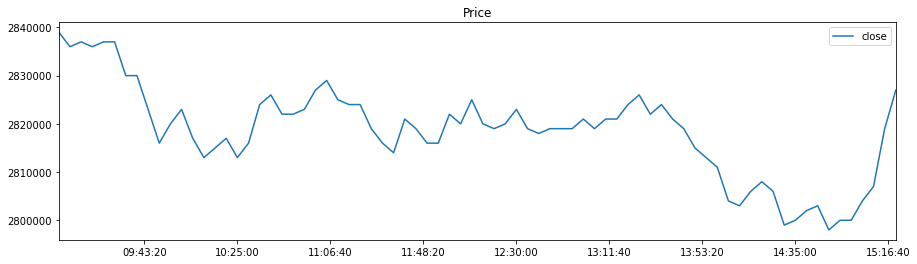

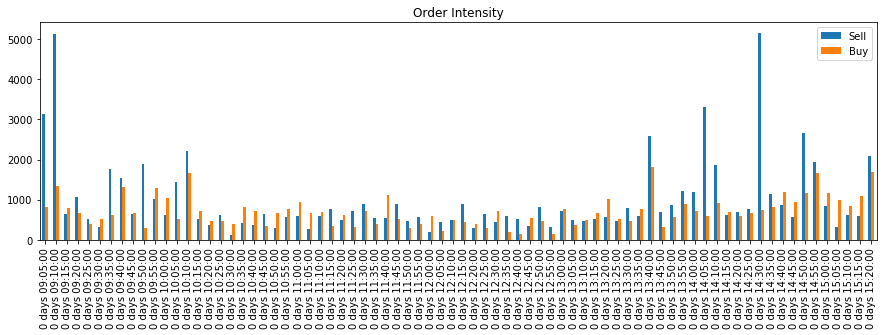

In [3]:
data[['close']].plot(figsize=(15,4), legend = True, title="Price")
data[['Sell','Buy']].plot.bar(figsize=(15,4), legend = True, title="Order Intensity")
plt.show()

In [4]:
Sell_I = data['Sell'].sum(axis = 0) / 76
Buy_I = data['Buy'].sum(axis = 0) / 76
Total_I= Sell_I + Buy_I

print("Sell_Intensity:", Sell_I)
print("Buy_Intensity:", Buy_I)
print("Total_Intensity:", Total_I)

Sell_Intensity: 978.2631578947369
Buy_Intensity: 712.1315789473684
Total_Intensity: 1690.3947368421054


In [5]:
def objective(init):
    a = init[0]
    d = init[1]
    r = init[2]
    
    eb = r * Buy_I
    u = (Buy_I - eb) / (a * (1-d))
    es = Sell_I - a * d * u
    
    if (a < 0.02) or (d < 0.02) or (a > 0.98) or (d > 0.98) or (u <=0) or (eb <=0) or (es <=0):
        return (math.inf)
    
    L = 0
    for i in range(76):
        B = data['Buy'][i]
        S = data['Sell'][i]

        k1 = -u - B * math.log (1+(u/eb))
        k2 = -u - S * math.log (1+(u/es))
        k3 = -B * math.log(1+(u/eb)) - S * math.log(1+(u/es))
        km = np.max([k1,k2,k3])

        inLog = a * d * math.exp(k1-km) + a * (1-d) * math.exp(k2-km) + (1-a) * math.exp(k3-km)
        if (inLog <= 0):
            return (math.inf)
        L = L + math.log(inLog) + B * math.log(eb + u) + S * math.log(es + u) - (eb + es) + km
    return(-L)

In [6]:
result = pd.DataFrame(columns=['L','Alpha','Delta','Mu','Eb','Es'])
for arange in np.arange(0.1,1,0.1):
    for drange in np.arange(0.1,1,0.1):
        for grange in np.arange(0.1,1,0.1):
            sol = optimize.minimize(objective,[arange,drange,grange], method = 'CG')
            a = sol.x[0]
            d = sol.x[1]
            r = sol.x[2]
            eb = r * Buy_I
            u = (Buy_I - eb) / (a * (1-d))
            es = Sell_I - a * d * u
            
            tmp = pd.DataFrame()
            tmp.loc[0,'L'] = sol.fun
            tmp['Alpha'] = a
            tmp['Delta'] = d
            tmp['Mu'] = u
            tmp['Eb'] = eb
            tmp['Es'] = es
            result = result.append(tmp)

In [7]:
optimal = result.sort_values(by=['L']).iloc[0]
PIN = optimal[1] * optimal[3] / (optimal[1] * optimal[3] + optimal[4] + optimal[5])

In [8]:
print("Alpha: ", optimal[1])
print("Delta: ", optimal[2])
print("Mu: ", optimal[3])
print("Eb: ", optimal[4])
print("Es: ", optimal[5])
print("PIN: ", PIN)

Alpha:  0.187945048862
Delta:  0.979999454616
Mu:  2011.32986499
Eb:  704.570982987
Es:  607.804264103
PIN:  0.223627938205


In [9]:
a = optimal[1]
G = 1-optimal[2]
B = optimal[2]

pu = 1/2 + a * (G - B) /2
pd = 1/2 - a * (G - B) /2

print(pu, pd)

0.409786479049 0.590213520951
